# Lenet + cifar10数据集

## 1.定义模型架构

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

model = nn.Sequential(
    # 二维卷积通道，输入通道，输出通道，核的大小，padding，激活函数，池化
    nn.Conv2d(3, 32, kernel_size=3, padding=1), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    # LeNet架构
    nn.Conv2d(32, 64, kernel_size=3), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    # 通常指的是将嵌套的列表、元组或多维数组转换为一维的列表或数组
    nn.Flatten(),
    # 线性变换，激活
    nn.Linear(3136, 256), nn.Sigmoid(),
    nn.Linear(256, 10)
    # nn.Sigmoid(),
    # 线性变换
    # nn.Linear(84, 10)
    )

print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=256, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=256, out_features=10, bias=True)
)


## 2.数据加载

In [3]:
# 定义批量大小
batch_size = 256

# 数据预处理（标准化参数来自 CIFAR-10 的官方统计）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10 的RGB均值
                        std=[0.2470, 0.2435, 0.2616])    # CIFAR-10 的RGB标准差
])

# 加载训练集和测试集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 创建数据迭代器
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3.评估函数

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## 4.训练函数

In [5]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## 5.进行训练

loss 0.012, train acc 1.000, test acc 0.649
58182.8 examples/sec on cuda:0


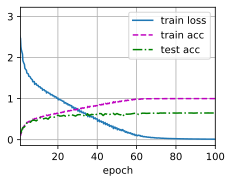

In [10]:
lr, num_epochs = 0.99, 100
train_ch6(model, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 6.打印结果和参数量

In [9]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            896
├─Sigmoid: 1-2                           --
├─AvgPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─Sigmoid: 1-5                           --
├─AvgPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            803,072
├─Sigmoid: 1-9                           --
├─Linear: 1-10                           2,570
Total params: 825,034
Trainable params: 825,034
Non-trainable params: 0